In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [2]:
#Load in data
dogData = pd.read_csv('dogData.csv')
catData = pd.read_csv('catData.csv')

In [3]:
dogData.index = dogData['PetID']
catData.index = catData['PetID']
dogData.drop(columns = 'PetID', inplace = True)
catData.drop(columns = 'PetID', inplace = True)

In [4]:
dogData.head(3)

,Age,Quantity,Fee,VideoAmt,Description,PhotoAmt,AdoptionSpeed,PureBreed_0,PureBreed_1,Breed_20,...,kind,little,lovely,playful,puppy,shelter,siblings,stray,sweet,trained
PetID,,,,,,,,,,,,,,,,,,,,,
3422e4906,1,1,0,0,Their pregnant mother was dumped by her irresp...,7,1,1,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5842f1ff5,4,1,150,0,"Good guard dog, very alert, active, obedience ...",8,1,1,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
850a43f90,1,1,0,0,This handsome yet cute boy is up for adoption....,3,1,1,0,0,...,0.0,0.0,0.0,0.225212,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
catData.head(3)

,Age,Quantity,Fee,VideoAmt,Description,PhotoAmt,AdoptionSpeed,PureBreed_0,PureBreed_1,Breed_243,...,kittens,little,lovely,old,playful,rescued,siblings,stray,sweet,trained
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,3,1,100,0,Nibble is a 3+ month old ball of cuteness. He ...,1,1,0,1,0,...,0.0,0.240664,0.0,0.206106,0.182644,0.232571,0.0,0.000000,0.0,0.0
6296e909a,1,1,0,0,I just found it alone yesterday near my apartm...,2,0,0,1,0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
d24c30b4b,3,1,0,0,This is a stray kitten that came to my house. ...,2,1,0,1,0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.675031,0.0,0.0


Split predictor and response variables into separate dataframes.

In [6]:
X_dog = dogData.drop(columns = 'AdoptionSpeed')
y_dog = dogData.AdoptionSpeed
X_cat = catData.drop(columns = 'AdoptionSpeed')
y_cat = catData.AdoptionSpeed

Split data into train & test.

In [7]:
X_train_dog, X_test_dog, y_train_dog, y_test_dog = train_test_split(X_dog, y_dog, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.3, random_state=42)

Looking at the Variance Inflation Factor of the dependent variables.

In [8]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [9]:
final_iv_dog, IV_dog = data_vars(X_train_dog, y_train_dog)
final_iv_cat, IV_cat = data_vars(X_train_cat, y_train_cat)

/Users/SIMONA/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/SIMONA/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
features_dog = list(IV_dog[(IV_dog['IV'] >= 0.01) & (IV_dog['IV'] <= 0.8)]['VAR_NAME'])
features_cat = list(IV_cat[(IV_cat['IV'] >= 0.01) & (IV_cat['IV'] <= 0.8)]['VAR_NAME'])

X2_dog = X_train_dog[features_dog]
X2_cat = X_train_cat[features_cat]

In [13]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns

        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')


In [14]:
X1_dog = X2_dog._get_numeric_data()
X1_cat = X2_cat._get_numeric_data()
final_df_dog, final_vif_dog = iterate_vif(X1_dog)
final_df_cat, final_vif_cat = iterate_vif(X1_cat)

Iteration # 1


/Users/SIMONA/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing FurLength_1 with VIF of inf
Iteration # 2
Removing PureBreed_0 with VIF of inf
Iteration # 3


/Users/SIMONA/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/SIMONA/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing Size_1 with VIF of inf
Iteration # 4
Removing Sterilized_0 with VIF of inf
Iteration # 5


/Users/SIMONA/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing Vaccinated_0 with VIF of 23.136849
Iteration # 6
Removing Breed_307 with VIF of 6.795547
Iteration # 7
Removing Size_2 with VIF of 5.875348
Iteration # 8
Complete
Iteration # 1


/Users/SIMONA/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/SIMONA/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing Dewormed_0 with VIF of inf
Iteration # 2
Removing FurLength_1 with VIF of inf
Iteration # 3


/Users/SIMONA/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/SIMONA/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing PureBreed_0 with VIF of inf
Iteration # 4
Removing Sterilized_0 with VIF of inf
Iteration # 5
Removing Vaccinated_0 with VIF of 22.800765
Iteration # 6
Removing Size_2 with VIF of 5.395839
Iteration # 7
Complete


In [15]:
X_train_dog = final_df_dog
X_train_cat = final_df_cat

In [16]:
X_test_dog=X_test_dog[X_train_dog.columns]
X_test_cat=X_test_cat[X_train_cat.columns]

### Logistic Regression 

In [17]:
def run_regression_accuracy(X_train, y_train, X_test, y_test):
  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  cm = confusion_matrix(y_test, y_pred)
  print('\nConfusion matrix: \n',cm)

  print('\nClassification report: \n',classification_report(y_test, y_pred))

  logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()
  
  return logreg

#### Logistic regression for dog adoption

Accuracy of logistic regression classifier on test set: 0.81

Confusion matrix: 
 [[  37  413]
 [  29 1828]]

Classification report: 
               precision    recall  f1-score   support

           0       0.56      0.08      0.14       450
           1       0.82      0.98      0.89      1857

    accuracy                           0.81      2307
   macro avg       0.69      0.53      0.52      2307
weighted avg       0.77      0.81      0.75      2307



/Users/SIMONA/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


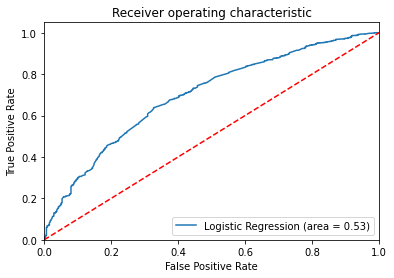

Accuracy of logistic regression classifier on test set: 0.71

Confusion matrix: 
 [[  19  551]
 [  18 1388]]

Classification report: 
               precision    recall  f1-score   support

           0       0.51      0.03      0.06       570
           1       0.72      0.99      0.83      1406

    accuracy                           0.71      1976
   macro avg       0.61      0.51      0.45      1976
weighted avg       0.66      0.71      0.61      1976



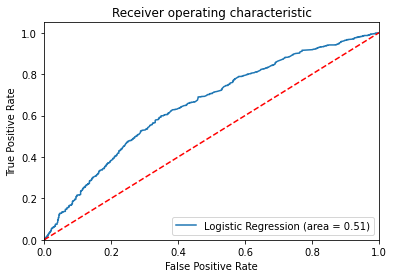

In [18]:
logreg_dog = run_regression_accuracy(X_train_dog, y_train_dog, X_test_dog, y_test_dog)

#### Logistic regression for cat adoption

Accuracy of logistic regression classifier on test set: 0.71

Confusion matrix: 
 [[  19  551]
 [  18 1388]]

Classification report: 
               precision    recall  f1-score   support

           0       0.51      0.03      0.06       570
           1       0.72      0.99      0.83      1406

    accuracy                           0.71      1976
   macro avg       0.61      0.51      0.45      1976
weighted avg       0.66      0.71      0.61      1976



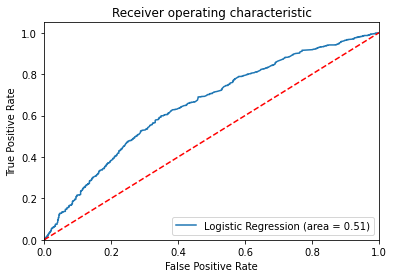

In [28]:
logreg_cat = run_regression_accuracy(X_train_cat, y_train_cat, X_test_cat, y_test_cat)

### Random Forest

In [19]:
def run_random_forest(X_train, X_test, y_train, y_test):
    # Instantiate model with 1000 decision trees
    rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
    # Train the model on training data
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion matrix: \n',cm)

    print('\nClassification report: \n',classification_report(y_test, y_pred))

    rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

    plt.figure()
    plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return rf

#### Random forest classifier for dog adoption

Accuracy of random forest classifier on test set: 0.80

Confusion matrix: 
 [[  59  391]
 [  75 1782]]

Classification report: 
               precision    recall  f1-score   support

           0       0.44      0.13      0.20       450
           1       0.82      0.96      0.88      1857

    accuracy                           0.80      2307
   macro avg       0.63      0.55      0.54      2307
weighted avg       0.75      0.80      0.75      2307



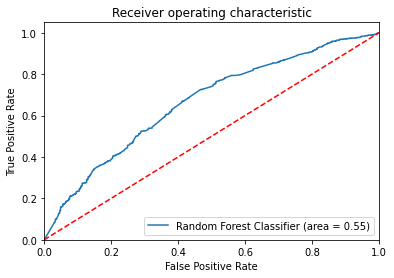

RandomForestClassifier(n_estimators=1000, random_state=42)

In [20]:
run_random_forest(X_train_dog, X_test_dog, y_train_dog, y_test_dog)

#### Random forest classifier for cat adoption

Accuracy of random forest classifier on test set: 0.68

Confusion matrix: 
 [[ 126  444]
 [ 196 1210]]

Classification report: 
               precision    recall  f1-score   support

           0       0.39      0.22      0.28       570
           1       0.73      0.86      0.79      1406

    accuracy                           0.68      1976
   macro avg       0.56      0.54      0.54      1976
weighted avg       0.63      0.68      0.64      1976



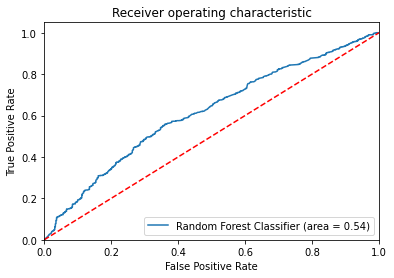

RandomForestClassifier(n_estimators=1000, random_state=42)

In [21]:
run_random_forest(X_train_cat, X_test_cat, y_train_cat, y_test_cat)

### XGBoost

In [31]:
def run_XGB_classifier(X_train, X_test, y_train, y_test):
    data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
    xgb_cla = xgb.XGBClassifier(use_label_encoder=False, colsample_bytree = 0.3, learning_rate = 0.1,
                    max_depth = 5, alpha = 10, n_estimators = 10)
    xgb_cla.fit(X_train, y_train)
    y_pred = xgb_cla.predict(X_test)
    
    print('Accuracy of XGB classifier on test set: {:.2f}'.format(xgb_cla.score(X_test, y_test)))
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion matrix: \n',cm)

    print('\nClassification report: \n',classification_report(y_test, y_pred))

    xgb_roc_auc = roc_auc_score(y_test, xgb_cla.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, xgb_cla.predict_proba(X_test)[:,1])

    plt.figure()
    plt.plot(fpr, tpr, label='XGB Classifier (area = %0.2f)' % xgb_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()


    return xgb_cla


#### XGBoost classifier for dog adoption

[15:37:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGB classifier on test set: 0.80

Confusion matrix: 
 [[   0  450]
 [   0 1857]]

Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       450
           1       0.80      1.00      0.89      1857

    accuracy                           0.80      2307
   macro avg       0.40      0.50      0.45      2307
weighted avg       0.65      0.80      0.72      2307



/Users/SIMONA/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


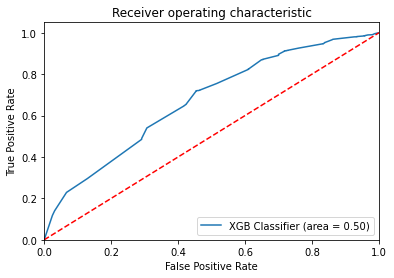

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [27]:
run_XGB_classifier(X_train_dog, X_test_dog, y_train_dog, y_test_dog)

#### XGBoost classifier for cat adoption

[15:45:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGB classifier on test set: 0.71

Confusion matrix: 
 [[   0  570]
 [   0 1406]]

Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       570
           1       0.71      1.00      0.83      1406

    accuracy                           0.71      1976
   macro avg       0.36      0.50      0.42      1976
weighted avg       0.51      0.71      0.59      1976



/Users/SIMONA/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


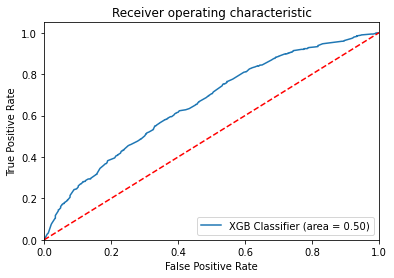

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [32]:
run_XGB_classifier(X_train_cat, X_test_cat, y_train_cat, y_test_cat)